In [ ]:
%pip install -q transformers torchinfo

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

# Dataset

In [3]:
train = pd.read_csv("./content/train.csv")
test = pd.read_csv("./content/test.csv")
train.head()

,rate,text
0,4,Очень понравилось. Были в начале марта с соба...
1,5,В целом магазин устраивает.\nАссортимент позво...
2,5,"Очень хорошо что открылась 5 ка, теперь не над..."
3,3,Пятёрочка громко объявила о том как она заботи...
4,3,"Тесно, вечная сутолока, между рядами трудно ра..."


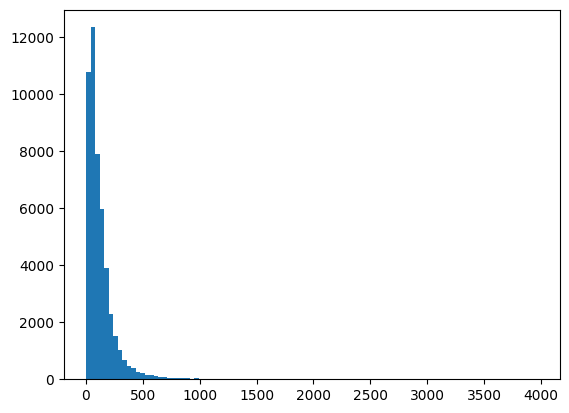

In [ ]:
plt.hist(train.text.map(len), bins=100);

In [5]:
train.text.map(len).describe()

,text
count,48665.000000
mean,125.037686
std,139.946020
min,2.000000
25%,45.000000
50%,86.000000
75%,157.000000
max,3965.000000


In [4]:
train.groupby(by="rate").count() / len(train)

,text
rate,
1,0.085030
2,0.049522
3,0.125881
4,0.203884
5,0.535683


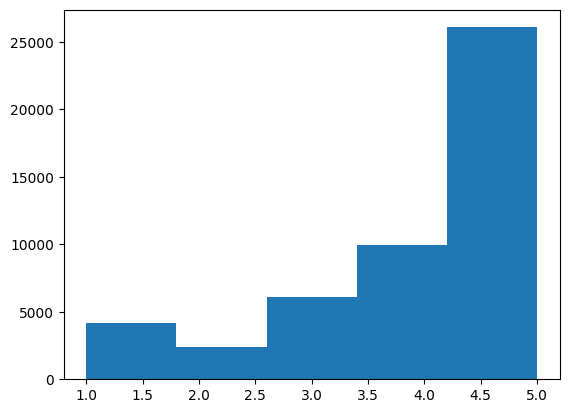

In [7]:
plt.hist(train.rate, bins=5);

In [ ]:
ltoi = {i + 1: i for i in range(5)}
itol = {i: l for l, i in ltoi.items()}
ltoi, itol

({1: 0, 2: 1, 3: 2, 4: 3, 5: 4}, {0: 1, 1: 2, 2: 3, 3: 4, 4: 5})

In [6]:
train.rate = train.rate.map(ltoi)

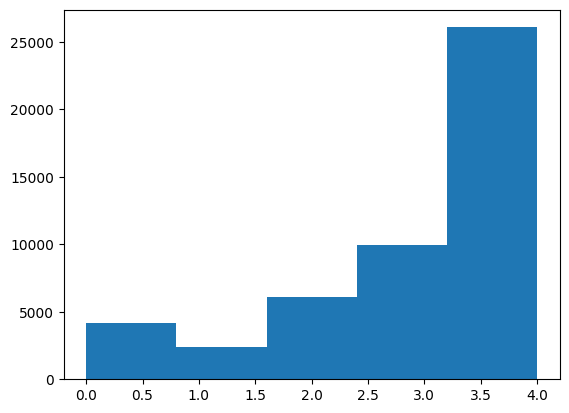

In [10]:
plt.hist(train.rate, bins=5);

In [ ]:
from typing import List, Tuple

from torch.utils.data import Dataset


class Ratings(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data: pd.DataFrame = data
        self.text: List[str] = data.text.to_list()
        self.targets = None
        if "rate" in data:
            self.targets = data.rate.tolist()

    def __getitem__(self, index) -> Tuple[str, int] | str:
        if self.targets:
            return (self.text[index], self.targets[index])
        return self.text[index]

    def __len__(self) -> int:
        return len(self.text)

In [8]:
train_ds = Ratings(train)
test_ds = Ratings(test)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler

dev_ratio = 0.1

# Get the labels for each sample in the dataset
targets = [
    train_ds[i][1] for i in range(len(train_ds))
]  # Assuming labels are at index 1 in each sample

train_ids, dev_ids = train_test_split(
    range(len(train_ds)), test_size=dev_ratio, stratify=targets, random_state=42
)

train_sampler = SubsetRandomSampler(train_ids)
dev_sampler = SubsetRandomSampler(dev_ids)

# Tokenizer

In [9]:
from transformers import AutoTokenizer

model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
tokenizer

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [15]:
tok_seq = tokenizer(train.text.to_list())

In [17]:
for i in tok_seq:
    print(i)

input_ids
token_type_ids
attention_mask


In [16]:
tok_len = pd.Series([len(s) for s in tok_seq["input_ids"]])
tok_len.describe()

,0
count,48665.000000
mean,29.848166
std,32.160162
min,3.000000
25%,12.000000
50%,21.000000
75%,36.000000
max,930.000000


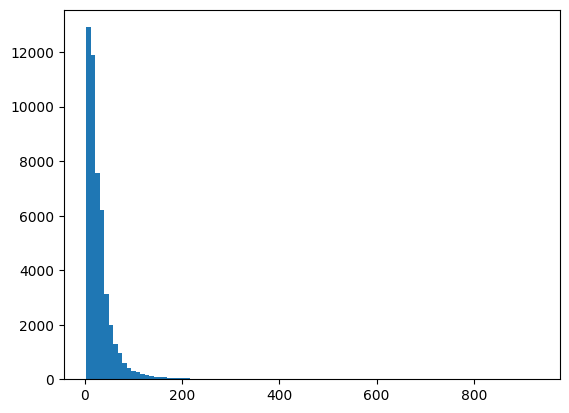

In [19]:
plt.hist([len(s) for s in tok_seq["input_ids"]], bins=100);

In [ ]:
def collate(batch):
    if isinstance(batch[0], tuple):
        tok_inp = tokenizer(
            [batch[i][0] for i in range(len(batch))],
            padding=True,
            truncation=True,
            return_tensors="pt",
        )
        targets = [batch[i][1] for i in range(len(batch))]
        return tok_inp, targets

    tok_inp = tokenizer(
        [batch[i] for i in range(len(batch))],
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
    return tok_inp

In [ ]:
from torch.utils.data import DataLoader

batch_sizes = {"train": 64, "dev": 64, "test": 64}
train_loader = DataLoader(
    train_ds, batch_size=batch_sizes["train"], sampler=train_sampler, collate_fn=collate
)
dev_loader = DataLoader(
    train_ds, batch_size=batch_sizes["dev"], sampler=dev_sampler, collate_fn=collate
)
test_loader = DataLoader(test_ds, batch_size=batch_sizes["test"], collate_fn=collate)

# Model

In [ ]:
import torch.nn as nn
from transformers import AutoModel


class RatingModel(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.model_name = model_name
        self.n_classes = 5
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.classifier = nn.Sequential(
            nn.Linear(312, 768),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(768, 64),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(64, self.n_classes),
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        hidden_state = output[0]  # batch_size, sequence_length, hidden_size
        hidden_state = hidden_state[
            :, 0
        ]  # The [CLS] token is the first token in each sequence and is designed by BERT as a "summary" representation of the entire sequence.
        output = self.classifier(hidden_state)
        return output

In [13]:
model = RatingModel(model_name)
model

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

RatingModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_af

In [14]:
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
# Calculate model parameters memory
param_memory = sum(p.numel() for p in model.parameters()) * 4  # in bytes for float32
param_memory_MB = param_memory / (1024**2)  # in MB
print(f"Model Parameters Memory: {param_memory_MB} MB")

Model Parameters Memory: 112.47136306762695 MB


In [ ]:
# Gradients memory is the same as parameters
gradients_memory_MB = (
    sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024**2)
)
print(f"Gradients Memory: {gradients_memory_MB} MB")

Gradients Memory: 1.1059761047363281 MB


In [17]:
# Adjust based on optimizer type (assuming Adam optimizer here)
optimizer_factor = 2  # 1 for SGD w/ momentum, 2 for Adam
optimizer_memory_MB = gradients_memory_MB * optimizer_factor
print(f"Optimizer Memory: {optimizer_memory_MB} MB")

Optimizer Memory: 2.2119522094726562 MB


In [ ]:
from torchinfo import summary

batch = next(iter(train_loader))
print(f'Input shape: {batch[0]["input_ids"].shape}')
summary(
    model,
    input_data=[
        batch[0]["input_ids"],
        batch[0]["attention_mask"],
        batch[0]["token_type_ids"],
    ],
)

Input shape: torch.Size([64, 163])


Layer (type:depth-idx)                                       Output Shape              Param #
RatingModel                                                  [64, 5]                   --
├─BertModel: 1-1                                             [64, 312]                 --
│    └─BertEmbeddings: 2-1                                   [64, 163, 312]            --
│    │    └─Embedding: 3-1                                   [64, 163, 312]            (26,154,336)
│    │    └─Embedding: 3-2                                   [64, 163, 312]            (624)
│    │    └─Embedding: 3-3                                   [1, 163, 312]             (638,976)
│    │    └─LayerNorm: 3-4                                   [64, 163, 312]            (624)
│    │    └─Dropout: 3-5                                     [64, 163, 312]            --
│    └─BertEncoder: 2-2                                      [64, 163, 312]            --
│    │    └─ModuleList: 3-6                                  --         

# Saving and loading

In [ ]:
def save(model, path: str) -> None:
    torch.save(model.state_dict(), path)


def load(path: str):
    model = RatingModel(model_name)
    model.load_state_dict(torch.load(path, weights_only=True))
    return model

# Train

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
model.to(device)

RatingModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_af

In [25]:
n_epochs = 10

opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
history = {
    "train_loss": [],
    "dev_loss": [],
    "train_time": [],
    "val_accuracy": [],
    "val_f1_macro": [],
    "val_f1_weighted": [],
}

In [ ]:
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1}/{n_epochs}")
    epoch_start_time = time.time()

    # Training
    model.train()
    train_loss_temp = 0.0
    total_train_samples = 0

    for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        token_type_ids = inputs["token_type_ids"].to(device)
        targets = torch.tensor(targets).to(device)
        opt.zero_grad()

        logits = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(logits, targets)

        loss.backward()
        opt.step()

        batch_size = targets.size(0)
        train_loss_temp += loss.detach().cpu().item() * batch_size
        total_train_samples += batch_size

    avg_train_loss = train_loss_temp / total_train_samples
    history["train_loss"].append(avg_train_loss)

    # Validation
    model.eval()
    dev_loss_temp = 0.0
    total_dev_samples = 0
    correct_predictions = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in tqdm(dev_loader, desc="Validation", leave=False):
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)
            token_type_ids = inputs["token_type_ids"].to(device)
            targets = torch.tensor(targets).to(device)
            opt.zero_grad()

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = loss_fn(logits, targets)

            batch_size = targets.size(0)
            dev_loss_temp += loss.detach().cpu().item() * batch_size
            total_dev_samples += batch_size

            predictions = logits.argmax(dim=1)
            correct_predictions += (predictions == targets).sum().item()

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Average validation loss and accuracy for the epoch
    avg_dev_loss = dev_loss_temp / total_dev_samples
    val_accuracy = correct_predictions / total_dev_samples
    history["dev_loss"].append(avg_dev_loss)
    history["val_accuracy"].append(val_accuracy)

    # Calculate F1 Score
    history["val_f1_weighted"].append(f1_score(all_targets, all_predictions, average="weighted"))
    history["val_f1_macro"].append(f1_score(all_targets, all_predictions, average="macro"))

    # Epoch timing
    epoch_time = time.time() - epoch_start_time
    history["train_time"].append(epoch_time)

    # Save model
    if len(history["val_f1_weighted"]) > 1 and history["val_f1_weighted"][-1] > history["val_f1_weighted"][-2]:
        save(model, "rating_model.pt")

    # Log epoch results
    print(
        f"Epoch [{ep + 1}/{n_epochs}] - "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Dev Loss: {avg_dev_loss:.4f} | "
        f"Val Accuracy: {val_accuracy * 100:.2f}% | "
        f"Val F1 Score weighted: {history["val_f1_weighted"][-1]:.4f} | "
        f"Val F1 Score macro: {history["val_f1_macro"][-1]:.4f} | "
        f"Time: {epoch_time:.2f} seconds"
    )


Epoch 1/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.8276 | Dev Loss: 0.8755 | Val Accuracy: 65.58% | Val F1 Score: 0.6317 | Time: 35.71 seconds

Epoch 2/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.8179 | Dev Loss: 0.8930 | Val Accuracy: 65.47% | Val F1 Score: 0.6292 | Time: 33.69 seconds

Epoch 3/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.8093 | Dev Loss: 0.9010 | Val Accuracy: 65.27% | Val F1 Score: 0.6200 | Time: 34.05 seconds

Epoch 4/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.8004 | Dev Loss: 0.9045 | Val Accuracy: 65.50% | Val F1 Score: 0.6232 | Time: 34.02 seconds

Epoch 5/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.7916 | Dev Loss: 0.9225 | Val Accuracy: 65.46% | Val F1 Score: 0.6176 | Time: 32.64 seconds

Epoch 6/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.7774 | Dev Loss: 0.9139 | Val Accuracy: 65.50% | Val F1 Score: 0.6304 | Time: 33.61 seconds

Epoch 7/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

Validation:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.7689 | Dev Loss: 0.9314 | Val Accuracy: 65.37% | Val F1 Score: 0.6264 | Time: 33.68 seconds

Epoch 8/10


Training:   0%|          | 0/609 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Predict

In [32]:
model.eval()
predictions = []
with torch.no_grad():
    for inputs in tqdm(test_loader, leave=False):
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        token_type_ids = inputs["token_type_ids"].to(device)
        outputs = model(input_ids, attention_mask, token_type_ids)
        predictions.extend(outputs.argmax(1).tolist())

  0%|          | 0/191 [00:00<?, ?it/s]

In [33]:
submission = pd.read_csv("/content/sample_submission.csv")
submission.rate = predictions
submission.rate = submission.rate.map(itol)
submission.head()

,index,rate
0,0,5
1,1,3
2,2,5
3,3,5
4,4,1


In [34]:
submission.to_csv("submission.csv", index=False)